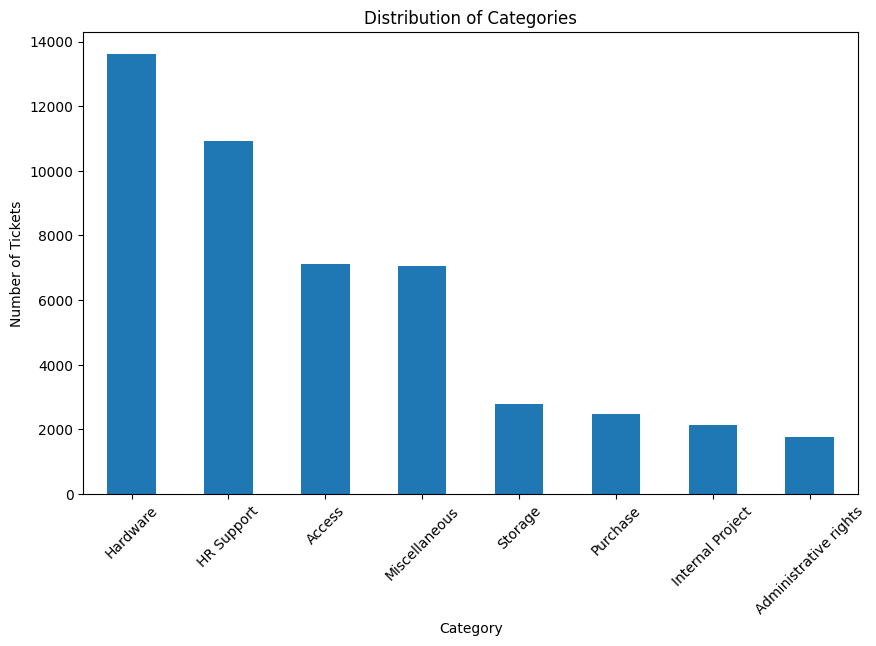

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
def load_data(filepath):
    data = pd.read_csv(filepath)
    data.drop_duplicates(inplace=True)
    return data

# Visualize the distribution of the categories
def visualize_category_distribution(data):
    plt.figure(figsize=(10, 6))
    data['Topic_group'].value_counts().plot(kind='bar')
    plt.title('Distribution of Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Tickets')
    plt.xticks(rotation=45)
    plt.show()

if __name__ == "__main__":
    filepath = 'tickets_dataset.csv'
    data = load_data(filepath)
    visualize_category_distribution(data)  # Visualize category distribution


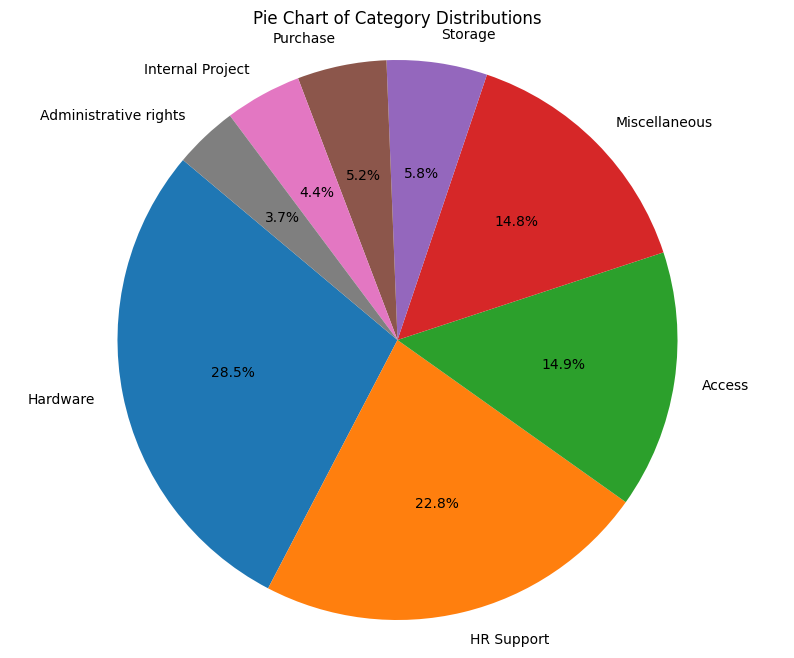

In [2]:
def plot_pie_chart(data):
    # Calculate the distribution of categories
    category_distribution = data['Topic_group'].value_counts()
    
    # Create a pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
    plt.title('Pie Chart of Category Distributions')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

if __name__ == "__main__":
    filepath = 'tickets_dataset.csv'
    data = pd.read_csv(filepath)
    plot_pie_chart(data)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

print(f"Model Training in progress...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load the data
def load_data(filepath):
    data = pd.read_csv(filepath)
    data.drop_duplicates(inplace=True)
    return data

# Preprocess text data
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.isalpha() and word.lower() not in stop_words]
    cleaned_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return " ".join(cleaned_words)


# Prepare data
def prepare_data(data):
    data['Document'] = data['Document'].apply(preprocess_text)
    return data['Document'], data['Topic_group']


# Train and evaluate the model using a single split for saving test data
def train_and_evaluate_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)
    X_train_counts = vectorizer.fit_transform(X_train)
    X_test_counts = vectorizer.transform(X_test)

    model = MultinomialNB(alpha=0.05)
    model.fit(X_train_counts, y_train)

    y_pred = model.predict(X_test_counts)
    acc = accuracy_score(y_test, y_pred)
    print(f"Model Trained")
    print(f"Test Accuracy: {acc}")

    # Save test data
    joblib.dump(X_test, 'X_test.pkl')
    joblib.dump(y_test, 'y_test.pkl')

    return model, vectorizer


if __name__ == "__main__":
    filepath = 'tickets_dataset.csv'
    data = load_data(filepath)
    X, y = prepare_data(data)
    model, vectorizer = train_and_evaluate_model(X, y)
    # Save model and vectorizer
    joblib.dump(model, 'naive_bayes_model.pkl')
    joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


Model Training in progress...
Model Trained
Test Accuracy: 0.7995401337792643


<Figure size 1000x1000 with 0 Axes>

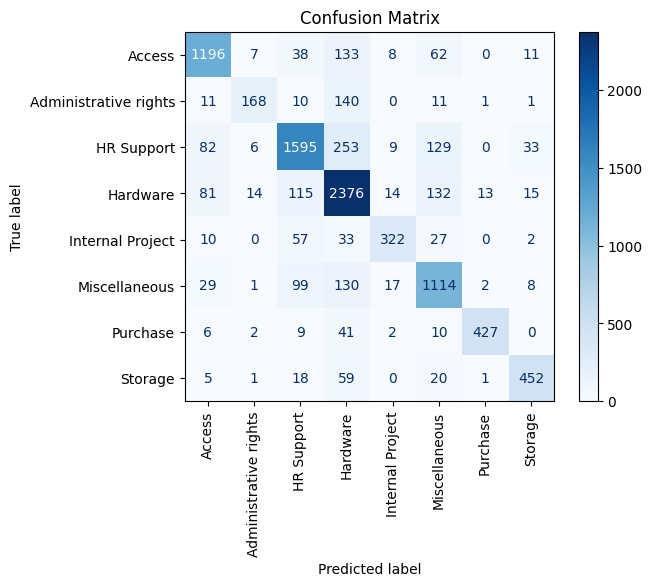

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# Load preprocessed test data
X_test = joblib.load('X_test.pkl')
y_test = joblib.load('y_test.pkl')

# Load model and vectorizer from disk
model = joblib.load('naive_bayes_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

X_test_counts = vectorizer.transform(X_test)

# Predict using the model
y_pred = model.predict(X_test_counts)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import joblib
from ipywidgets import widgets, VBox, HBox, Button, Label, Layout
from IPython.display import display

# Load the trained model and vectorizer
model = joblib.load('naive_bayes_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_category(document):
    # Function to predict the category of a ticket
    doc_vector = vectorizer.transform([document])
    prediction = model.predict(doc_vector)
    return prediction[0]

def on_button_clicked(b):
    # Event handler for the submit button
    input_text = text_area.value
    if input_text.strip() != '':
        prediction = predict_category(input_text)
        result_label.value = f'Predicted Category: {prediction}'
    else:
        result_label.value = 'Please enter a valid IT support ticket text.'

# UI elements
text_area = widgets.Textarea(
    value='',
    placeholder='Type your IT support ticket here...',
    description='Ticket:',
    layout=Layout(width='50%', height='100px'),
    disabled=False
)

button = Button(
    description='Classify Ticket',
    button_style='success',
    tooltip='Click to classify the IT support ticket',
    icon='check'
)

result_label = Label(
    value='',
    layout=Layout(width='50%')
)

button.on_click(on_button_clicked)

# Display UI
display(VBox([HBox([text_area, button]), result_label]))